# SCHEMAS

In [1]:
import operator
from typing import List, Dict, Optional, Any
from pydantic import BaseModel, Field
from typing_extensions import TypedDict, Annotated

In [2]:
class PDFHashData(BaseModel):
    """Hash information for the PDF file."""
    sha1: str = Field(..., description="SHA1 hash of the PDF file")
    md5: str = Field(..., description="MD5 hash of the PDF file")

class ExtractedImage(BaseModel):
    """Information about an extracted image."""
    page_number: int = Field(..., description="Page number the image was extracted from (0-based)")
    base64_data: str = Field(..., description="Base64-encoded image data")
    image_format: str = Field(..., description="Image format (e.g., 'png', 'jpg')")
    phash: Optional[str] = Field(None, description="Perceptual hash of the image")
    saved_path: Optional[str] = Field(None, description="Path where the image was saved")
    image_sha1: Optional[str] = Field(None, description="SHA1 hash of the image data")

class ExtractedURL(BaseModel):
    """Information about an extracted URL."""
    url: str = Field(..., description="The extracted URL")
    page_number: int = Field(..., description="Page number where the URL was found")
    url_type: str = Field(..., description="Type of URL (e.g., 'annotation', 'text')")
    coordinates: Optional[Dict[str, float]] = Field(None, description="Coordinates of the URL if from an annotation")
    is_external: Optional[bool] = Field(None, description="Whether the URL is external")
    xref: Optional[int] = Field(None, description="The PDF cross-reference number of the link annotation object")

In [3]:
class PDFExtractionState(TypedDict):
    """
    State for the PDF Extraction agent.
    Manages the extraction of visual and structural data from a PDF.
    """
    # --- Inputs ---
    file_path: str
    output_directory: str
    pages_to_process: Optional[List[int]] # List of 0-based page numbers to process
    number_of_pages_to_process: int
    session_id: Optional[str]  # Added for session management

    # --- Outputs ---
    pdf_hash: Optional[PDFHashData]
    page_count: Optional[int]
    extracted_images: List[ExtractedImage]
    extracted_urls: Annotated[List[ExtractedURL], operator.add]

    # --- Error Tracking ---
    # Using Annotated with operator.add allows LangGraph to automatically
    # aggregate errors from parallel nodes, just like in static_analysis.
    errors: Annotated[List[str], operator.add]


class PDFExtractionInputState(TypedDict):
    file_path: str
    output_directory: str
    number_of_pages_to_process: int
    session_id: Optional[str]  # Added for session management


class PDFExtractionOutputState(TypedDict):
    output_directory: str  # Added to pass session directory to other agents
    session_id: str        # Added to pass session ID to other agents
    pdf_hash: Optional[PDFHashData]
    page_count: Optional[int]
    pages_to_process: List[int]
    extracted_images: List[ExtractedImage]
    extracted_urls: List[ExtractedURL]
    errors: Annotated[List[str], operator.add]

# NODES

In [39]:
import base64
from PIL import Image
import io
import pathlib
import os
import inspect
from datetime import datetime
import asyncio

from loguru import logger

from pdf_hunter.shared.utils.hashing import calculate_file_hashes
from pdf_hunter.shared.utils.image_extraction import extract_pages_as_base64_images, calculate_image_phash, get_pdf_page_count, save_image
from pdf_hunter.shared.utils.url_extraction import extract_urls_from_pdf
from pdf_hunter.shared.utils.file_operations import ensure_output_directory
from pdf_hunter.shared.utils.qr_extraction import process_pdf_for_qr_codes
from pdf_hunter.shared.utils.serializer import dump_state_to_file
from pdf_hunter.config import MAXIMUM_PAGES_TO_PROCESS

In [5]:
def setup_session(state: PDFExtractionState):
    """
    Initializes the PDF extraction by validating paths, calculating hashes,
    generating session_id (or using provided one), and creating session-specific directory structure.
    """
    try:
        file_path = state['file_path']
        base_output_directory = state.get('output_directory', 'output')
        number_of_pages_to_process = state["number_of_pages_to_process"]
        provided_session_id = state.get('session_id')
        
        # Agent start event
        logger.info(f"🚀 Starting PDF extraction session",
                    agent="PdfExtraction",
                    node="setup_session",
                    event_type="AGENT_START",
                    file_path=file_path,
                    provided_session_id=provided_session_id)

        # Validate inputs
        if not file_path:
            raise ValueError("file_path is required")
        
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"PDF file not found: {file_path}")
        
        if not os.path.isfile(file_path):
            raise ValueError(f"Path is not a file: {file_path}")
        
        if number_of_pages_to_process <= 0:
            raise ValueError(f"number_of_pages_to_process must be positive, got: {number_of_pages_to_process}")
        
        # Apply maximum pages cap
        if number_of_pages_to_process > MAXIMUM_PAGES_TO_PROCESS:
            logger.warning(f"Requested {number_of_pages_to_process} pages exceeds maximum limit of {MAXIMUM_PAGES_TO_PROCESS}. Capping to {MAXIMUM_PAGES_TO_PROCESS}.",
                          agent="PdfExtraction",
                          node="setup_session")
            number_of_pages_to_process = MAXIMUM_PAGES_TO_PROCESS

        # 1. Calculate file hashes (needed for validation and session_id generation)
        hashes = calculate_file_hashes(file_path)
        pdf_hash = PDFHashData(sha1=hashes["sha1"], md5=hashes["md5"])

        # 2. Use provided session_id or generate new one
        if provided_session_id:
            session_id = provided_session_id
            logger.info(
                f"📝 Using provided session_id",
                agent="PdfExtraction",
                node="setup_session",
                session_id=session_id,
                expected_sha1=pdf_hash.sha1[:16]
            )
            # Validate that provided session_id matches file hash
            if not session_id.startswith(pdf_hash.sha1):
                logger.warning(
                    f"⚠️ Provided session_id doesn't match file SHA1 hash",
                    agent="PdfExtraction",
                    node="setup_session",
                    session_id=session_id,
                    file_sha1=pdf_hash.sha1[:16]
                )
        else:
            # Generate new session_id using {sha1}_{timestamp}
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            session_id = f"{pdf_hash.sha1}_{timestamp}"
            logger.info(
                f"🆕 Generated new session_id",
                agent="PdfExtraction",
                node="setup_session",
                session_id=session_id
            )

        # 3. Create session-specific output directory
        # Check if base_output_directory already includes the session_id (when called from API)
        # to avoid double-nesting like output/{session_id}/{session_id}/
        if base_output_directory.endswith(session_id):
            # API server already created output/{session_id}/, use it directly
            session_output_directory = base_output_directory
        else:
            # Standalone mode: base_output_directory is just "output", append session_id
            session_output_directory = os.path.join(base_output_directory, session_id)
        
        pdf_extraction_directory = os.path.join(session_output_directory, "pdf_extraction")

        # 4. Ensure directories exist
        ensure_output_directory(pathlib.Path(session_output_directory))
        ensure_output_directory(pathlib.Path(pdf_extraction_directory))

        # 5. Get total page count
        page_count = get_pdf_page_count(file_path)

        # 6. Validate and set pages to process
        if number_of_pages_to_process > page_count:
            logger.warning(
                f"⚠️ Requested {number_of_pages_to_process} pages but PDF only has {page_count} pages. Processing all available pages.",
                agent="PdfExtraction",
                node="setup_session",
            )
            number_of_pages_to_process = page_count
        
        pages_to_process = list(range(number_of_pages_to_process))
        
        # Session created event with all metadata
        logger.info(
            f"✅ Session initialized | ID: {session_id} | SHA1: {pdf_hash.sha1[:16]}... | MD5: {pdf_hash.md5[:16]}... | Pages (to process/total): {number_of_pages_to_process}/{page_count}",
            agent="PdfExtraction",
            node="setup_session",
            event_type="SESSION_CREATED",
            session_id=session_id,
            pdf_hash_sha1=pdf_hash.sha1,
            pdf_hash_md5=pdf_hash.md5,
            total_pages=page_count,
            pages_to_process=number_of_pages_to_process,
            session_output_dir=session_output_directory,
            pdf_extraction_dir=pdf_extraction_directory,
        )

        result = {
            "session_id": session_id,
            "output_directory": session_output_directory,  # Update to session-specific directory
            "pdf_hash": pdf_hash,
            "page_count": page_count,
            "pages_to_process": pages_to_process
        }
        return result

    except Exception as e:
        error_msg = f"Error in setup_session: {e}"
        logger.exception("❌ Session setup failed",
                        agent="PdfExtraction",
                        node="setup_session",
                        event_type="ERROR",
                        error=str(e))
        return {"errors": [error_msg]}

In [6]:
def extract_pdf_images(state: PDFExtractionState):
    """
    Extracts images from the specified pages of the PDF, calculates their
    perceptual hash (phash), and saves them to the preprocessing subdirectory.
    """
    try:
        file_path = state['file_path']
        session_id = state.get('session_id')
        session_output_dir = state['output_directory']
        pdf_extraction_dir = pathlib.Path(os.path.join(session_output_dir, "pdf_extraction"))
        pages_to_process = state.get('pages_to_process')

        # If specific pages aren't defined, default to the first page.
        if not pages_to_process:
            pages_to_process = [0] if state.get('page_count', 0) > 0 else []

        # Image extraction start event
        logger.info("📸 Extracting images from PDF pages",
                    agent="PdfExtraction",
                    node="extract_images",
                    event_type="IMAGE_EXTRACTION_START",
                    session_id=session_id,
                    pages_count=len(pages_to_process),
                    dpi=150)

        # 1. Extract raw image data using our utility
        base64_images_data = extract_pages_as_base64_images(
            pdf_path=file_path,
            pages=pages_to_process,
            dpi=150,
            image_format="PNG"
        )

        extracted_images = []
        images_data = []  # For summary logging with all image details
        
        for img_data in base64_images_data:
            page_number = img_data['page_number']
            
            # 2. Decode image to calculate phash and save
            img_bytes = base64.b64decode(img_data["base64_data"])
            pil_image = Image.open(io.BytesIO(img_bytes))

            # 3. Calculate perceptual hash
            phash = calculate_image_phash(pil_image)

            # 4. Save the image file to pdf_extraction subdirectory
            saved_path = save_image(
                image=pil_image,
                output_dir=pdf_extraction_dir,
                page_number=page_number,
                image_format="PNG",
                phash=phash
            )

            # Progress logging (DEBUG level for per-image tracking)
            logger.debug(
                f"📸 Page {page_number} extracted | pHash: {phash} | Path: {saved_path.name}",
                agent="PdfExtraction",
                node="extract_images",
                session_id=session_id,
                page_number=page_number,
                phash=phash,
                saved_path=str(saved_path),
            )

            # 5. Create the structured ExtractedImage object
            extracted_image = ExtractedImage(
                page_number=page_number,
                base64_data=img_data["base64_data"],
                image_format=img_data["image_format"],
                phash=phash,
                saved_path=str(saved_path)
            )
            extracted_images.append(extracted_image)
            
            # Collect data for summary log
            images_data.append({
                "page_number": page_number,
                "phash": phash,
                "saved_path": str(saved_path),
                "base64_data": img_data["base64_data"]  # Include for remote rendering
            })

        # Summary with all images data
        logger.info(
            f"📸 Extracted {len(images_data)} images from PDF",
            agent="PdfExtraction",
            node="extract_images",
            event_type="IMAGE_EXTRACTION_PROGRESS",
            session_id=session_id,
            images_data=images_data,
        )

        # Completion event
        logger.success(
            f"✅ Image extraction complete | {len(extracted_images)} images processed",
            agent="PdfExtraction",
            node="extract_images",
            event_type="IMAGE_EXTRACTION_COMPLETE",
            session_id=session_id,
            images_extracted=len(extracted_images),
            pages_processed=len(pages_to_process),
        )

        return {"extracted_images": extracted_images}

    except Exception as e:
        error_msg = f"Error in extract_pdf_images: {e}"
        logger.exception("❌ Image extraction failed",
                        agent="PdfExtraction",
                        node="extract_images",
                        event_type="ERROR",
                        session_id=state.get('session_id'),
                        error=str(e))
        return {"errors": [error_msg]}

In [7]:
def find_embedded_urls(state: PDFExtractionState):
    """
    Extracts URLs from the specified pages of the PDF from both
    annotations and raw text.
    """
    try:
        file_path = state['file_path']
        session_id = state.get('session_id')
        pages_to_process = state.get('pages_to_process')

        # If specific pages aren't defined, default to the first page.
        if not pages_to_process:
            pages_to_process = [0] if state.get('page_count', 0) > 0 else []

        # URL extraction start event
        logger.info("🔗 Searching for embedded URLs",
                    agent="PdfExtraction",
                    node="find_urls",
                    event_type="URL_EXTRACTION_START",
                    session_id=session_id,
                    pages_to_scan=len(pages_to_process))

        # 1. Extract URL data using our final, validated utility
        url_data_list = extract_urls_from_pdf(
            pdf_path=file_path,
            specific_pages=pages_to_process
        )

        # 2. Convert the dictionaries into ExtractedURL Pydantic objects.
        extracted_urls = [ExtractedURL(**url_data) for url_data in url_data_list]

        # Calculate URL type breakdown
        url_type_counts = {}
        url_list = []
        for url_obj in extracted_urls:
            url_type_counts[url_obj.url_type] = url_type_counts.get(url_obj.url_type, 0) + 1
            url_list.append({
                "url": url_obj.url,
                "url_type": url_obj.url_type,
                "page_number": url_obj.page_number
            })

        # URLs found event (INFO level - just data, not suspicious)
        # Format URL preview for terminal (first 3 URLs)
        if url_list:
            url_preview = ", ".join([u["url"][:60] + ("..." if len(u["url"]) > 60 else "") for u in url_list[:3]])
            if len(url_list) > 3:
                url_preview += f" ... and {len(url_list) - 3} more"
            
            # Format type breakdown for display (escape braces for loguru)
            types_str = str(url_type_counts).replace('{', '{{').replace('}', '}}')
            
            logger.info(
                f"🔗 Found {len(extracted_urls)} embedded URLs | Types: {types_str} | URLs: {url_preview}",
                agent="PdfExtraction",
                node="find_urls",
                event_type="URLS_FOUND",
                session_id=session_id,
                url_count=len(extracted_urls),
                url_type_breakdown=url_type_counts,
                url_list=url_list,
            )
        else:
            logger.info(
                "🔗 No embedded URLs found",
                agent="PdfExtraction",
                node="find_urls",
                event_type="URLS_FOUND",
                session_id=session_id,
                url_count=0,
                url_type_breakdown={},
                url_list=[],
            )

        return {"extracted_urls": extracted_urls}

    except Exception as e:
        error_msg = f"Error in find_embedded_urls: {e}"
        logger.exception("❌ URL extraction failed",
                        agent="PdfExtraction",
                        node="find_urls",
                        event_type="ERROR",
                        session_id=state.get('session_id'),
                        error=str(e))
        return {"errors": [error_msg]}

In [8]:
def scan_qr_codes(state: PDFExtractionState):
    """
    Extracts QR codes from the specified pages of the PDF.
    """
    try:
        file_path = state['file_path']
        session_id = state.get('session_id')
        pages_to_process = state.get('pages_to_process')

        # If specific pages aren't defined, default to the first page.
        if not pages_to_process:
            pages_to_process = [0] if state.get('page_count', 0) > 0 else []

        # QR scan start event
        logger.info("📱 Scanning for QR codes",
                    agent="PdfExtraction",
                    node="scan_qr",
                    event_type="QR_SCAN_START",
                    session_id=session_id,
                    pages_to_scan=len(pages_to_process))

        # 1. Extract QR code data using our utility (auto-detect caller's function name)
        caller_name = inspect.currentframe().f_code.co_name
        qr_data_list = process_pdf_for_qr_codes(
            pdf_path=file_path,
            specific_pages=pages_to_process,
            log_agent="PdfExtraction",
            log_caller=caller_name  # Automatically gets "scan_qr_codes"
        )

        # 2. Convert the dictionaries into ExtractedURL Pydantic objects.
        extracted_qr_urls = [ExtractedURL(**qr_data) for qr_data in qr_data_list]

        # Build QR code list with all details
        qr_list = []
        for qr_url in extracted_qr_urls:
            qr_list.append({
                "url": qr_url.url,
                "page_number": qr_url.page_number
            })

        # QR codes found event (WARNING level - suspicious!)
        if extracted_qr_urls:
            # Format QR URLs for terminal display (first 2)
            qr_preview = " | ".join([f"Page {qr['page_number']}: {qr['url'][:80]}" for qr in qr_list[:2]])
            if len(qr_list) > 2:
                qr_preview += f" ... and {len(qr_list) - 2} more"
            
            logger.warning(
                f"⚠️  QR codes detected: {len(extracted_qr_urls)} codes found | {qr_preview}",
                agent="PdfExtraction",
                node="scan_qr",
                event_type="QR_CODES_FOUND",
                session_id=session_id,
                qr_count=len(extracted_qr_urls),
                qr_list=qr_list,
            )
        else:
            logger.info(
                "📱 No QR codes found",
                agent="PdfExtraction",
                node="scan_qr",
                event_type="QR_SCAN_COMPLETE",
                session_id=session_id,
                qr_count=0,
            )
        
        return {"extracted_urls": extracted_qr_urls}

    except Exception as e:
        error_msg = f"Error in scan_qr_codes: {e}"
        logger.exception("❌ QR code scanning failed",
                        agent="PdfExtraction",
                        node="scan_qr",
                        event_type="ERROR",
                        session_id=state.get('session_id'),
                        error=str(e))
        return {"errors": [error_msg]}

In [40]:
async def finalize_extraction(state: PDFExtractionState) -> dict:
    """
    Final node that logs completion of PDF extraction.
    This ensures the frontend knows the agent has finished.
    
    Args:
        state: Current extraction state
        
    Returns:
        Empty dict (no state changes, just logging)
    """
    try:
        session_id = state.get('session_id', 'unknown')
        images_count = len(state.get('extracted_images', []))
        urls_count = len(state.get('extracted_urls', []))
        errors_count = len(state.get('errors', []))

        # Save the final state to a JSON file for debugging and records
        session_output_directory = state.get("output_directory", "output")
        session_id = state.get("session_id", "unknown_session")
        finalizer_directory = os.path.join(session_output_directory, "pdf_extraction")
        await asyncio.to_thread(os.makedirs, finalizer_directory, exist_ok=True)
        json_filename = f"pdf_extraction_final_state_session_{session_id}.json"
        json_path = os.path.join(finalizer_directory, json_filename)
        await dump_state_to_file(state, json_path)
        
        if errors_count > 0:
            logger.warning(
                f"⚠️ PDF Extraction complete with {errors_count} error(s)",
                agent="PdfExtraction",
                node="finalize_extraction",
                event_type="EXTRACTION_COMPLETE_WITH_ERRORS",
                session_id=session_id,
                images_extracted=images_count,
                urls_found=urls_count,
                error_count=errors_count
            )
        else:
            logger.success(
                f"✅ PDF Extraction complete | Images: {images_count}, URLs: {urls_count}",
                agent="PdfExtraction",
                node="finalize_extraction",
                event_type="EXTRACTION_COMPLETE",
                session_id=session_id,
                images_extracted=images_count,
                urls_found=urls_count
            )
        
        return {}
        
    except Exception as e:
        error_msg = f"Error in finalize_extraction: {e}"
        logger.error(error_msg,
                    agent="PdfExtraction",
                    node="finalize_extraction",
                    session_id=state.get('session_id'),
                    exc_info=True)
        return {"errors": [error_msg]}

# GRAPH

In [41]:
from langgraph.graph import StateGraph, START, END
from pdf_hunter.config import PDF_EXTRACTION_CONFIG

In [42]:
preprocessing_builder = StateGraph(PDFExtractionState, input_schema=PDFExtractionInputState, output_schema=PDFExtractionOutputState)

preprocessing_builder.add_node("setup_session", setup_session)
preprocessing_builder.add_node("extract_pdf_images", extract_pdf_images)
preprocessing_builder.add_node("find_embedded_urls", find_embedded_urls)
preprocessing_builder.add_node("scan_qr_codes", scan_qr_codes)
preprocessing_builder.add_node("finalize_extraction", finalize_extraction)

preprocessing_builder.add_edge(START, "setup_session")

preprocessing_builder.add_edge("setup_session", "extract_pdf_images")
preprocessing_builder.add_edge("setup_session", "find_embedded_urls")
preprocessing_builder.add_edge("setup_session", "scan_qr_codes")

# All parallel tasks converge to finalize_extraction before END
preprocessing_builder.add_edge("extract_pdf_images", "finalize_extraction")
preprocessing_builder.add_edge("find_embedded_urls", "finalize_extraction")
preprocessing_builder.add_edge("scan_qr_codes", "finalize_extraction")

preprocessing_builder.add_edge("finalize_extraction", END)

preprocessing_graph = preprocessing_builder.compile()
preprocessing_graph = preprocessing_graph.with_config(PDF_EXTRACTION_CONFIG)

In [43]:
from IPython.display import Image, display

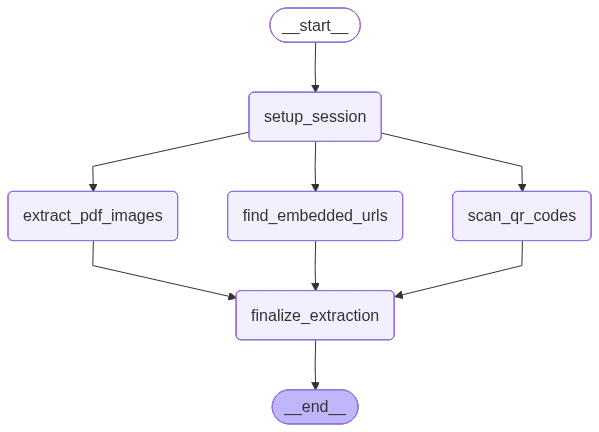

In [44]:
display(Image(preprocessing_graph.get_graph().draw_mermaid_png()))

# Test Helpers

In [15]:
calculate_file_hashes("/Users/gorelik/Courses/pdf-hunter/tests/assets/pdfs/87c740d2b7c22f9ccabbdef412443d166733d4d925da0e8d6e5b310ccfc89e13.pdf")

{'sha1': '242fc6a46e4b36fcc00a3cfaabefe29a8cf8a5c9',
 'md5': '000d3c8a528505461dea43b3ead5f422'}

In [16]:
get_pdf_page_count("/Users/gorelik/Courses/pdf-hunter/tests/assets/pdfs/87c740d2b7c22f9ccabbdef412443d166733d4d925da0e8d6e5b310ccfc89e13.pdf")

27

In [180]:
import base64
from io import BytesIO
from PIL import Image

In [17]:
res = extract_pages_as_base64_images("/Users/gorelik/Courses/pdf-hunter/tests/assets/pdfs/87c740d2b7c22f9ccabbdef412443d166733d4d925da0e8d6e5b310ccfc89e13.pdf", [0])

In [ ]:
res

In [19]:
image_data = base64.b64decode(res[0]["base64_data"])

In [20]:
image_stream = io.BytesIO(image_data)

In [25]:
# Image.open(image_stream)

In [47]:
from PIL import Image

In [23]:
calculate_image_phash(Image.open(image_stream))


'bc6f1b38c5c694c4'

In [24]:
extract_urls_from_pdf("/Users/gorelik/Courses/pdf-hunter/tests/assets/pdfs/87c740d2b7c22f9ccabbdef412443d166733d4d925da0e8d6e5b310ccfc89e13.pdf", [0, 1, 2, 3])

[{'url': 'https://www.foxit.com/fr/pdf-reader/',
  'page_number': 1,
  'url_type': 'annotation',
  'coordinates': {'x0': 338.0, 'y0': 801.0, 'x1': 503.0, 'y1': 820.0},
  'is_external': True,
  'xref': 53},
 {'url': 'https://www.foxit.com/fr/pdf-reader/',
  'page_number': 1,
  'url_type': 'annotation',
  'coordinates': {'x0': 243.0, 'y0': 804.0, 'x1': 555.0, 'y1': 831.0},
  'is_external': True,
  'xref': 54},
 {'url': 'https://www.foxit.com/fr/pdf-reader/',
  'page_number': 1,
  'url_type': 'annotation',
  'coordinates': {'x0': 189.0, 'y0': 485.0, 'x1': 617.0, 'y1': 771.0},
  'is_external': True,
  'xref': 55},
 {'url': 'https://www.foxit.com/',
  'page_number': 1,
  'url_type': 'text',
  'coordinates': None,
  'is_external': True,
  'xref': None},
 {'url': 'https://www.foxit.com/fr/pdf-reader/',
  'page_number': 3,
  'url_type': 'annotation',
  'coordinates': {'x0': 1.0, 'y0': 1.0, 'x1': 795.0, 'y1': 842.0},
  'is_external': True,
  'xref': 72}]

# Test Graph

In [ ]:
if __name__ == "__main__":
    import pprint

    # --- Configuration ---
    # This should point to a real PDF file for testing
    file_path = "/Users/gorelik/Courses/pdf-hunter/tests/assets/pdfs/87c740d2b7c22f9ccabbdef412443d166733d4d925da0e8d6e5b310ccfc89e13.pdf"
    output_directory = "output/preprocessing_results"

    # --- Initial State ---
    # This is the input to our graph.
    initial_state = {
        "file_path": file_path,
        "output_directory": output_directory,
        "number_of_pages_to_process": 3,  # We want to process only the first page (page 0)
    }

    print(f"--- Running Preprocessing on: {file_path} ---")

    # --- Invocation ---
    final_state = await preprocessing_graph.ainvoke(initial_state)

    print("\n--- Preprocessing Complete. ---")

    # --- Verification ---
    print("\n--- Verification ---")
    if final_state.get("errors"):
        print(f"Completed with {len(final_state['errors'])} error(s).")
    else:
        print("Completed successfully.")
        print(f"PDF Hash Calculated: {'Yes' if final_state.get('pdf_hash') else 'No'}")
        print(f"Images Extracted: {len(final_state.get('extracted_images', []))}")
        print(f"URL Findings: {len(final_state.get('extracted_urls', []))}")
        if final_state.get('extracted_urls'):
            print("Example URL Finding:")
            pprint.pprint(final_state['extracted_urls'][0])

In [32]:
final_state["extracted_urls"]

[ExtractedURL(url='https://www.foxit.com/fr/pdf-reader/', page_number=0, url_type='annotation', coordinates={'x0': 338.0, 'y0': 801.0, 'x1': 503.0, 'y1': 820.0}, is_external=True, xref=12),
 ExtractedURL(url='https://www.foxit.com/fr/pdf-reader/', page_number=0, url_type='annotation', coordinates={'x0': 243.0, 'y0': 804.0, 'x1': 555.0, 'y1': 831.0}, is_external=True, xref=13),
 ExtractedURL(url='https://www.foxit.com/fr/pdf-reader/', page_number=0, url_type='annotation', coordinates={'x0': 189.0, 'y0': 485.0, 'x1': 617.0, 'y1': 771.0}, is_external=True, xref=14),
 ExtractedURL(url='https://www.foxit.com/', page_number=0, url_type='text', coordinates=None, is_external=True, xref=None)]

In [33]:
final_state["pdf_hash"]

PDFHashData(sha1='35f89c35c980b7e916e35e937032eb77f1d9f7df', md5='644d782797b69b603e8b9c4975440e8c')

In [34]:
final_state.keys()

dict_keys(['output_directory', 'session_id', 'pdf_hash', 'page_count', 'pages_to_process', 'extracted_images', 'extracted_urls', 'errors'])

In [ ]:
pprint.pprint(final_state)